In [1]:
from sklearn.metrics import confusion_matrix
import xarray as xr
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [81]:
exp_files = {'snr1': '/home/rjackson/arming_the_edge/scripts/classifications/classification_trainsnrgt1.000000.nc',
             'snr1_3': '/home/rjackson/arming_the_edge/scripts/classifications/classification_trainsnrgt1.000000snrgt3.000000.nc',
             'snr1_3_5': '/home/rjackson/arming_the_edge/scripts/classifications/classification_trainsnrgt1.000000snrgt3.000000snrgt5.000000.nc',
             'snr1_3_5_10': '/home/rjackson/arming_the_edge/scripts/classifications/classification_trainsnrgt1.000000snrgt3.000000snrgt5.000000snrgt10.000000.nc',
             'snr5': '/home/rjackson/arming_the_edge/scripts/classifications/classification_trainsnrgt5.000000.nc',
             'snr10': '/home/rjackson/arming_the_edge/scripts/classifications/classification_trainsnrgt10.000000.nc',
             'snr3_5': '/home/rjackson/arming_the_edge/scripts/classifications/classification_trainsnrgt1.000000snrgt3.000000snrgt5.000000snrgt10.000000.nc',
             'snr3_10': '/home/rjackson/arming_the_edge/scripts/classifications/classification_trainsnrgt3.000000snrgt10.000000.nc'}
strings = {'snr1': 'SNR > 1 dB',
             'snr1_3': 'SNR > 1, \n 3 dB',
             'snr1_3_5': 'SNR > 1, \n 3, 5 dB',
             'snr1_3_5_10': 'SNR > 1, 3, \n 5, 10 dB',
             'snr5': 'SNR > 5 dB',
             'snr10': 'SNR > 10 dB',
             'snr3_5': 'SNR > 3, \n 5 dB',
             'snr3_10': 'SNR > 3, \n 10 dB'}

In [77]:
ds = xr.open_dataset(exp_files['snr1'])
ds

<xarray.Dataset>
Dimensions:           (label_pred: 13539, label_test: 2708, label_test_pred: 2708, label_train: 10831, label_train_pred: 10831, label_true: 13539)
Coordinates:
  * label_true        (label_true) int64 1 0 1 1 1 1 1 1 1 ... 0 1 1 1 1 1 0 0 1
  * label_pred        (label_pred) float32 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
  * label_train_pred  (label_train_pred) float32 0.0 0.0 0.0 0.0 ... 1.0 0.0 1.0
  * label_test_pred   (label_test_pred) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * label_train       (label_train) int64 0 0 0 0 0 0 0 1 1 ... 0 0 1 0 0 1 0 1
  * label_test        (label_test) int64 0 0 0 0 0 0 0 0 0 ... 1 0 0 0 1 0 0 0 0
Data variables:
    *empty*

In [23]:
positives = {}
positives_true = {}
negatives = {}
negatives_true = {}
true_pred = {}
totals = {}
for k in exp_files.keys():
    ds = xr.open_dataset(exp_files[k])
    positives[k] = np.where(ds.label_test_pred.values >= 1)
    positives_true[k] = np.where(ds.label_test.values >= 1)
    negatives[k] = np.where(ds.label_test_pred.values == 0)
    negatives_true[k] = np.where(ds.label_test.values == 0)
    totals[k] = len(ds.label_test.values)
    true_pred[k] = np.sum(np.equal(ds.label_test.values, ds.label_test_pred))
    ds.close()

specificity = {}
sensitivity = {}
accuracy = {}
for k in exp_files.keys():
    specificity[k] = 100 - len(np.setxor1d(positives[k], positives_true[k])) / np.sum(positives_true[k]) * 100
    sensitivity[k] = 100 - len(np.setxor1d(negatives[k], negatives_true[k])) / np.sum(negatives_true[k]) * 100
    accuracy[k] = 100 * true_pred[k]/totals[k]

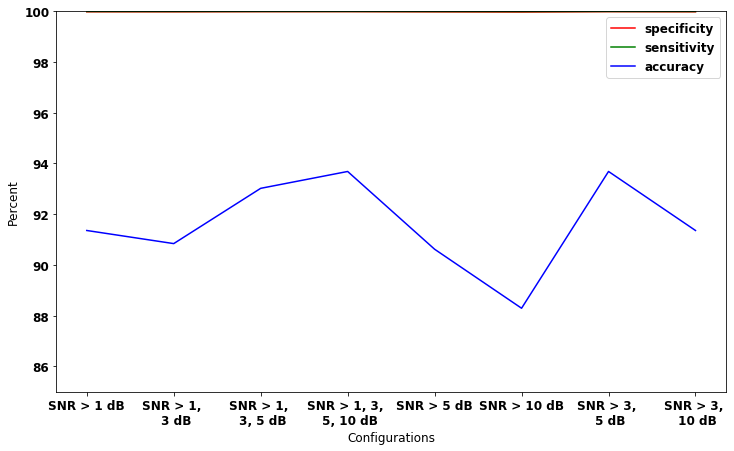

In [86]:
x_labels = [x for x in specificity.keys()]
spec = np.array([x for x in specificity.values()])
sens = np.array([x for x in sensitivity.values()])
accur = np.array([x for x in accuracy.values()])
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
font = {'size'   : 12}

matplotlib.rc('font', **font)
ax.plot(spec, color='r', label='specificity')
ax.plot(sens, color='g', label='sensitivity')
ax.plot(accur, color='b', label='accuracy')
ax.set_xticks(range(len(spec)))
ax.set_xticklabels([x_labels for x_labels in strings.values()])
ax.set_ylim([85, 100])
ax.set_xlabel('Configurations')
ax.set_ylabel('Percent')
ax.legend()
fig.savefig('accuracy_test.png', dpi=300)

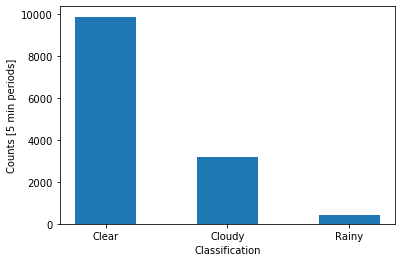

In [54]:
ds = xr.open_dataset(exp_files[k])
fig, ax = plt.subplots(1, 1)
n = ax.hist(ds.label_true, bins=np.array([-0.5, 0.5, 1.5, 2.5]), rwidth=0.5)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Clear', 'Cloudy', 'Rainy'])
ax.set_ylabel('Counts [5 min periods]')
ax.set_xlabel('Classification')
fig.savefig('dataset_summary.png', dpi=300)

In [52]:
n[0]/n[0].sum()

array([0.73040845, 0.23724056, 0.03235099])

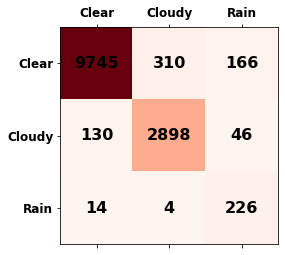

In [107]:
ds = xr.open_dataset(exp_files[k])
label_pred = ds.label_pred.values
label_true = ds.label_true.values
matrix = confusion_matrix(label_pred, label_true)
fig, ax = plt.subplots(1, 1)
ax.matshow(matrix, cmap='Reds')
for (i, j), z in np.ndenumerate(matrix):
    ax.text(j, i, '{:d}'.format(z), ha='center', va='center', color='k', fontsize=16)

ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels(['Clear', 'Cloudy', 'Rain'])
ax.set_yticklabels(['Clear', 'Cloudy', 'Rain'])
fig.savefig('confusion_matrix.png', dpi=300)